In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import head_direction as hd
#import place_stimulation as ps
import expipe
import os
import pathlib
import math
import numpy as np
import exdir
from exdir.plugins import quantities
from scipy.interpolate import interp1d
import pandas as pd
import sys
sys.path.append('../analyse_tutorial')
import data_processing as dp

In [3]:
speed_filter = 5 # m/s
pos_fs = 100 
f_cut = 6
box_xlen = 1 
box_ylen = 1 
binsize =  0.02
smoothing = 0.03


plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize') or
        k.endswith('titlesize')
    )
})

In [4]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

In [39]:
def make_rate_map(x, y, t, sptr, a, at, binsize, smoothing, mask_zero_occupancy=False):
    from matplotlib import gridspec

    fig = plt.figure()
    gs = gridspec.GridSpec(1,4)
    axs = [fig.add_subplot(g, projection=p) for g, p in zip(gs, [None, None, None, 'polar'])]
    spatial_map = sp.SpatialMap(
        x, y, t, sptr, box_size=1.0, bin_size=binsize)
    
    rate_map = spatial_map.rate_map(smoothing=smoothing, mask_zero_occupancy=mask_zero_occupancy)
    rate_map = np.rot90(rate_map)
    axs[0].imshow(rate_map, vmin=0, origin='lower')
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_title('channel group {} {}'.format(
        sptr.annotations['group_id'], sptr.annotations['name']))
    axs[1].plot(x, y, 'k', alpha=0.3)
    # Remove spikes that fall outside the range of times.
    # Otherwise, interpolation will fail when plotting spikes in scatter plot.
    sptr = sptr[(sptr > min(t)) & (sptr < max(t))]
    
    x_spike = interp1d(t,x)(sptr)
    y_spike = interp1d(t,y)(sptr)
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    
    axs[1].scatter(x_spike, y_spike, marker='.', color=(0.7, 0.2, 0.2), s=2)
    axs[1].set_ylim(1,0)
    axs[1].set_title('N spikes {}'.format(len(spike_times)))
    
    occupancy_map = spatial_map.occupancy_map(smoothing=smoothing, mask_zero_occupancy=mask_zero_occupancy)
    occupancy_map = np.rot90(occupancy_map)
    axs[2].imshow(occupancy_map, vmin=0, origin='lower')
    axs[2].set_xticks([])
    axs[2].set_yticks([])
    axs[2].set_title('occupancy')

    
    ang_bins, rate_ang = hd.head_direction_rate(sptr, a, at)
    hd_dir, hd_score = hd.head_direction_score(ang_bins, rate_ang)
    hd_dir = math.degrees(hd_dir)
    binsize = ang_bins[1] - ang_bins[0]
    axs[3].set_xticks([0, np.pi])
    axs[3].bar(ang_bins, rate_ang, width=binsize, color='b')
    axs[3].set_title('hd {:.2f}, {:.1f} deg'.format(hd_score, hd_dir))
    
    for ax in axs:
        ax.set_aspect(1)
        
def plot_waveform(wf, fig=None, axs=None, **kwargs):
    nrc = wf.shape[0]
    if fig is None:
        fig = plt.figure()
    axs = []
    ax = None
    for c in range(nrc):
        ax = fig.add_subplot(1, nrc, c+1, sharex=ax, sharey=ax)
        axs.append(ax)
    for c in range(nrc):
        axs[c].plot(wf[c, :], **kwargs)
        if c > 0:
            plt.setp(axs[c].get_yticklabels(), visible=False)
    return axs

In [40]:
action_id = "1833-010719-1"
channel_ids = [1]#range(8)
t_start = 0
t_stop = None

action  = actions[action_id]

data_path = dp.get_data_path(action)
root_group = exdir.File(
    data_path, plugins=[exdir.plugins.quantities])

In [41]:
max_speed = 1 # m/s only used for speed score
min_speed = 0.02 # m/s only used for speed score
position_sampling_rate = 100 # for interpolation
position_low_pass_frequency = 6 # for low pass filtering of position

box_size = [1.0, 1.0]
bin_size=0.02
smoothing = 0.05

In [42]:
data_loader = dp.Data(
    position_sampling_rate=position_sampling_rate, 
    position_low_pass_frequency=position_low_pass_frequency,
    box_size=box_size, bin_size=bin_size, stim_mask=True, baseline_duration=600,
)

In [43]:
# common values for all units == faster calculations
x, y, t, speed = map(data_loader.tracking(action_id).get, ['x', 'y', 't', 'v'])

#spike_times = data_loader.spike_train(action_id, channel_id, unit_id)

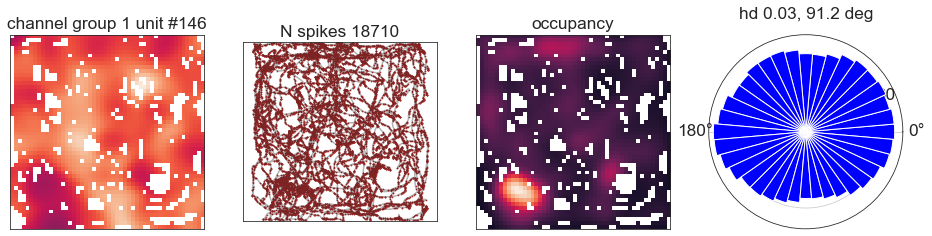

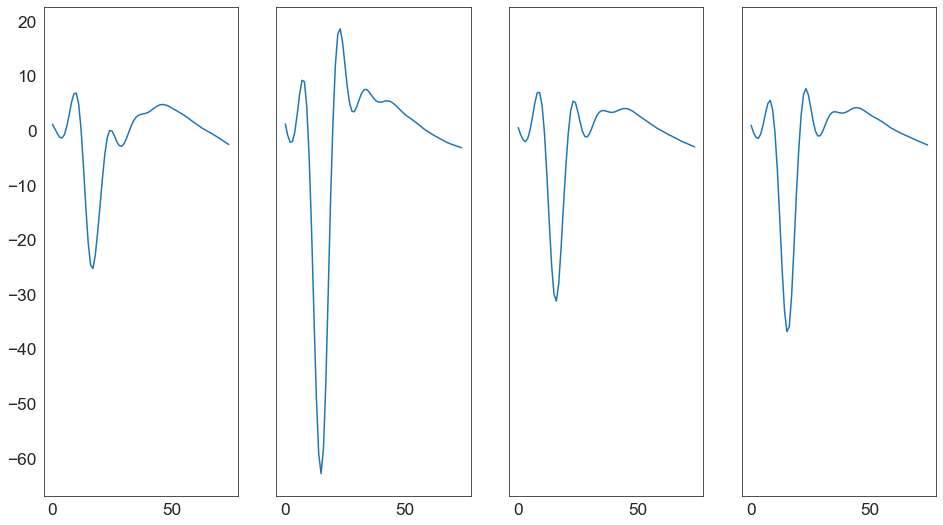

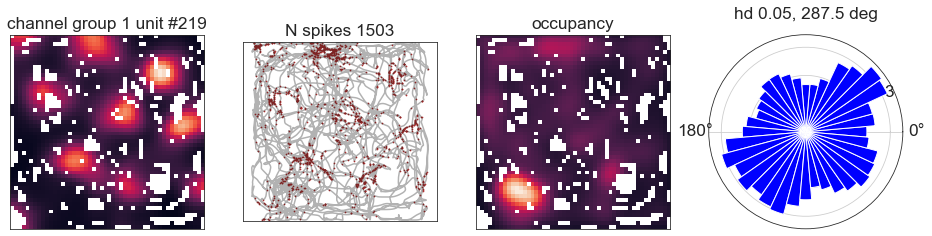

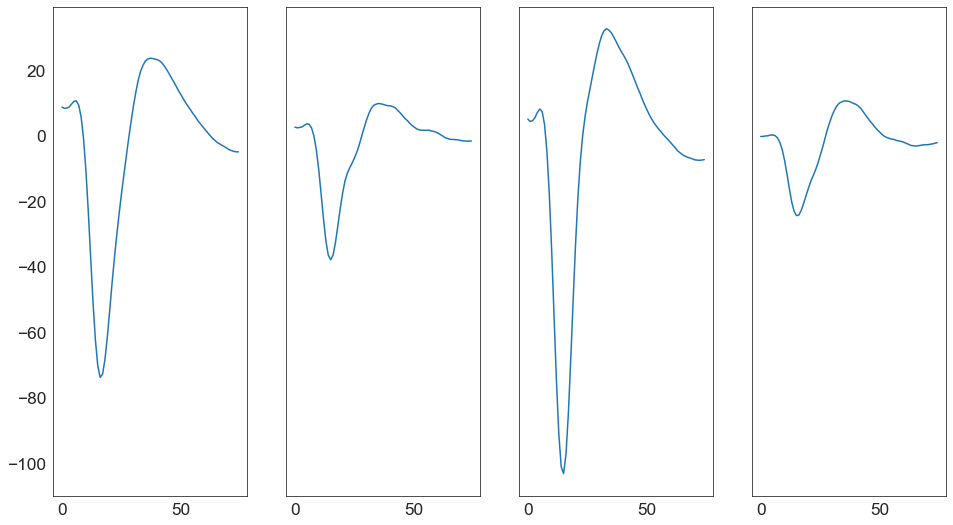

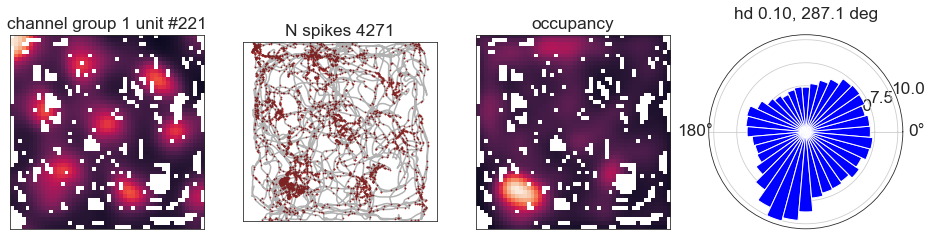

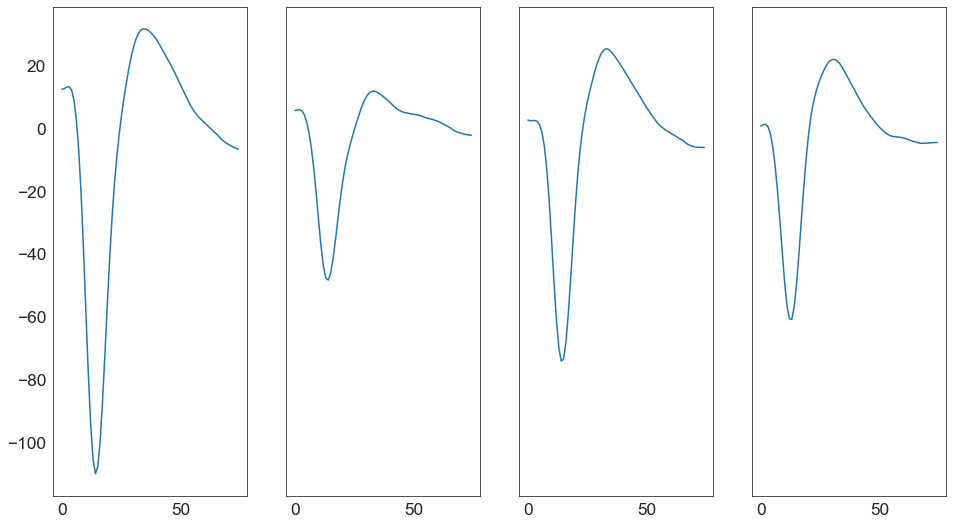

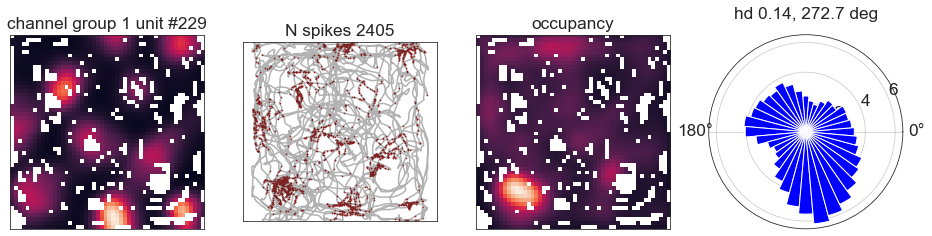

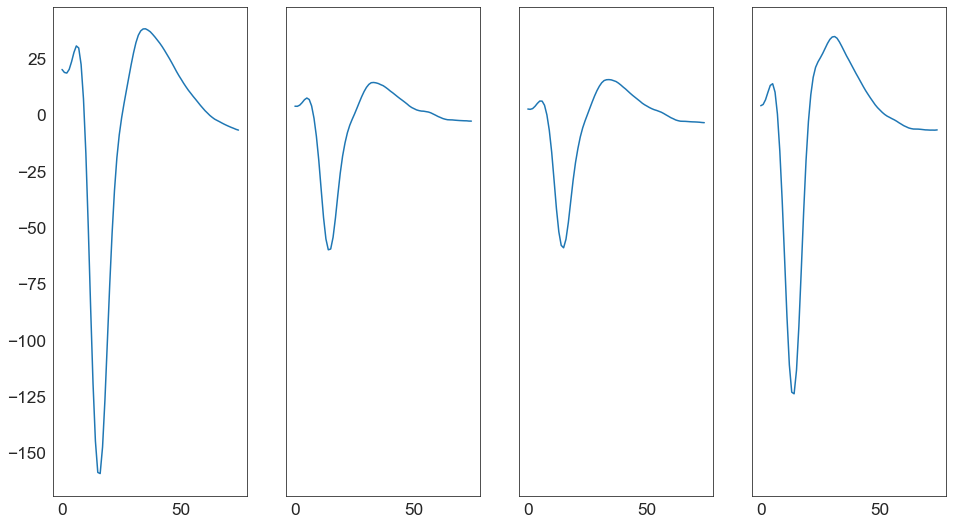

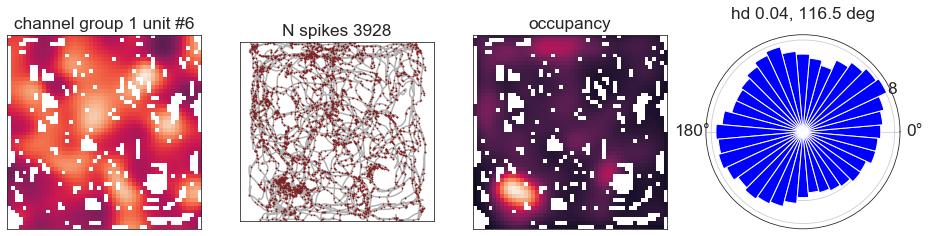

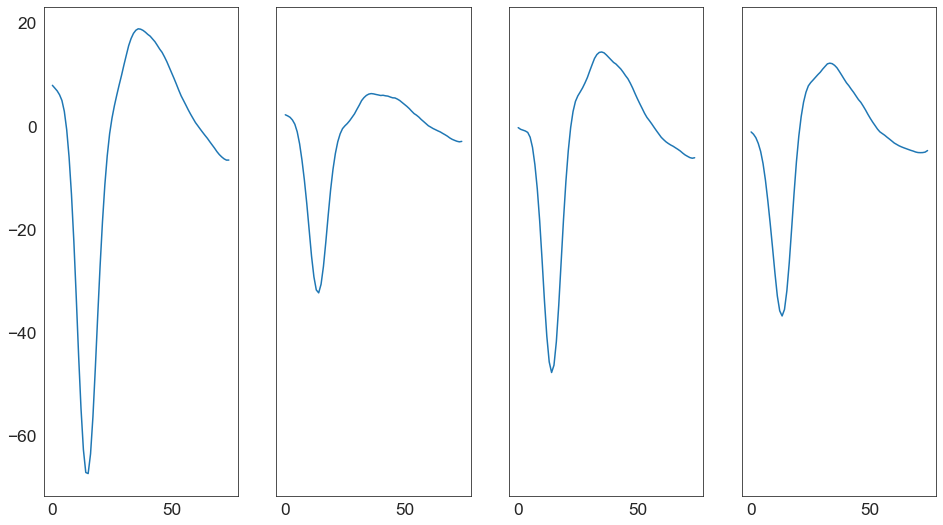

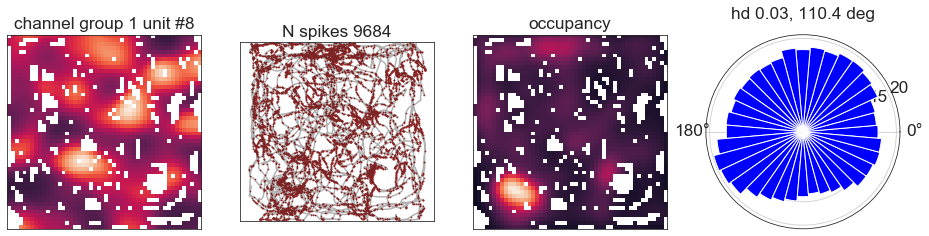

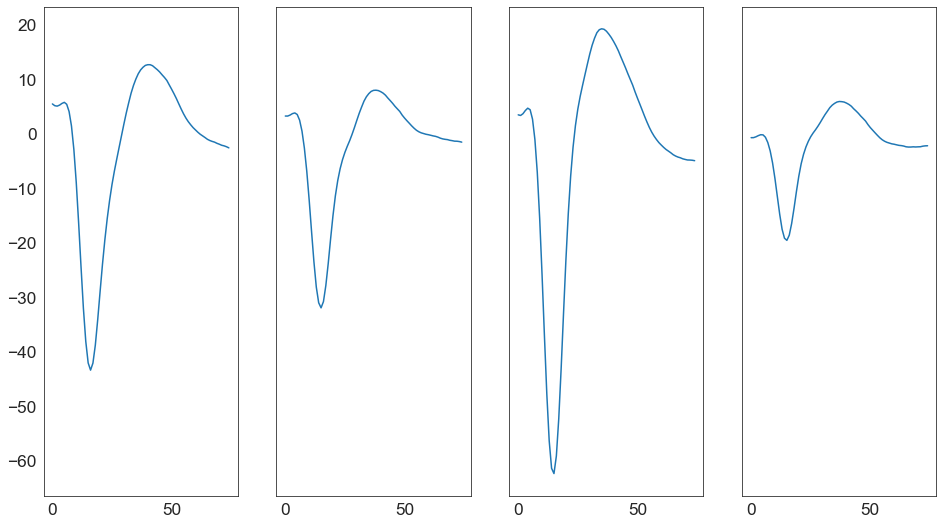

In [44]:

a, at = map(data_loader.head_direction(action_id).get, ['a', 't'])

if t_start is not None and t_stop is not None:
    mask = (t < t_stop) & (t > t_start)
    x, y, t = x[mask], y[mask], t[mask]

for channel_id in channel_ids:
    spike_trains = data_loader.spike_trains(action_id, channel_id)
    if len(spike_trains) == 0:
        print('No spikes in channel group {}'.format(channel_id))
        continue
            
#     spike_trains = dp.sort_by_cluster_id(spike_trains)
    for unit_id, spike_times in spike_trains.items():
        wf = data_loader.template(action_id, channel_id, unit_id).data
        if t_start is not None and t_stop is not None:
            spike_mask = (spike_times < t_stop) & (spike_times > t_start)
            spike_times = spike_times[spike_mask]
        make_rate_map(
            x, y, t, spike_times, 
            a, at, 
            binsize, smoothing, mask_zero_occupancy=True)
        plot_waveform(wf)